In [1]:
import numpy
import pandas as pd
import tqdm

https://www.cheminformania.com/ligand-docking-with-smina/

```python
fetch 5WIU
remove resn HOH
h_add elem O or elem N
select 1OYT-FSN, resn FSN #Create a selection called 1OYT-FSN from the ligand
select 1OYT-receptor, 1OYT and not 1OYT-FSN #Select all that is not the ligand
save 1OYT-FSN.pdb, 1OYT-FSN
save 1OYT-receptor.pdb, 1OYT-receptor
```


```
obabel 1OYT-receptor.pdb -xr -O 1OYT-receptor.pdbqt
obabel 1OYT-FSN.pdb -O 1OYT-FSN.pdbqt

```

```
smina.static -r 1OYT-receptor.pdbqt -l 1OYT-FSN.pdbqt --autobox_ligand 1OYT-FSN.pdbqt --autobox_add 8 --exhaustiveness 16 -o 1OYT-redock.pdbqt
```

In [15]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df = df['SMILES'][:5]

In [4]:
#convert ligand:
!obabel 5WIU-CAC.pdb -O 5WIU-CAC.pdbqt

#convert receptor
!obabel 5WIU-receptor.pdb -xr -O 5WIU-receptor.pdbqt

1 molecule converted
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is 5WIU-receptor.pdb)

1 molecule converted


In [18]:
df

0    Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...
1    C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...
2      C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1
3    C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...
4          COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C
Name: SMILES, dtype: object

In [ ]:
smina_score = list()
#./smina.static -r 5WIU-receptor.pdbqt --quiet -l nam.pdbqt --cpu 2 --autobox_ligand 5WIU-CAC.pdbqt --autobox_add 8 --log hi.log --exhaustiveness 4 >/dev/null
    
for count, smi in tqdm.tqdm_notebook(enumerate(df)):
    #convert the ligand:
    !obabel -:"$smi" --gen3d ---errorlevel 1 --partial_charges gasteiger -O nam.pdbqt >/dev/null
    
    #perform docking:    
    !./smina.static -r 5WIU-receptor.pdbqt --quiet -l nam.pdbqt --cpu 2 --autobox_ligand 5WIU-CAC.pdbqt --autobox_add 8 --log hi.log --exhaustiveness 4 --num_modes 1 -o "$count".pdbqt
    
    #save as a pdb:
    !obabel -ipdbqt "$count".pdbqt -O "$count".pdb
    #get docking score:
    myvar = !sed -n 26,26p hi.log | awk '{print $2}' -

    try:
        #record score
        smina_score.append(float(myvar[0]))
    except KeyboardInterrupt:
        raise
    except:
        pass

<ipython-input-19-a59e749c6ba0>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for count, smi in tqdm.tqdm_notebook(enumerate(df)):


1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 9.27113
Loop time 10.8096
1 molecule converted
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 7.67843
Loop time 9.54028
1 molecule converted
1 molecule converted

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
*************************************

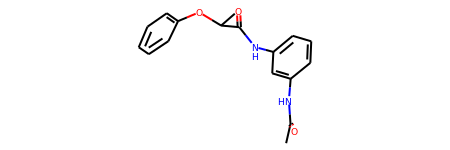

In [10]:
from rdkit import Chem
Chem.MolFromPDBFile('0.pdb')

(array([ 1.,  0.,  1.,  3.,  1.,  6.,  2.,  4.,  2.,  2.,  7.,  9., 11.,
         8.,  8., 21.,  9., 14., 23., 19., 23., 23., 22., 32., 20., 17.,
        20., 26., 27., 14., 11., 20., 12., 14., 15., 16., 10.,  2., 10.,
         7.,  6.,  8.,  5.,  1.,  5.,  0.,  2.,  0.,  2.,  2.]),
 array([-10.9, -10.8, -10.7, -10.6, -10.5, -10.4, -10.3, -10.2, -10.1,
        -10. ,  -9.9,  -9.8,  -9.7,  -9.6,  -9.5,  -9.4,  -9.3,  -9.2,
         -9.1,  -9. ,  -8.9,  -8.8,  -8.7,  -8.6,  -8.5,  -8.4,  -8.3,
         -8.2,  -8.1,  -8. ,  -7.9,  -7.8,  -7.7,  -7.6,  -7.5,  -7.4,
         -7.3,  -7.2,  -7.1,  -7. ,  -6.9,  -6.8,  -6.7,  -6.6,  -6.5,
         -6.4,  -6.3,  -6.2,  -6.1,  -6. ,  -5.9]),
 <BarContainer object of 50 artists>)

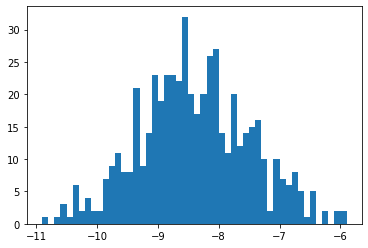

In [62]:
import matplotlib.pyplot as plt
plt.hist(smina_score, bins=50)

<AxesSubplot:>

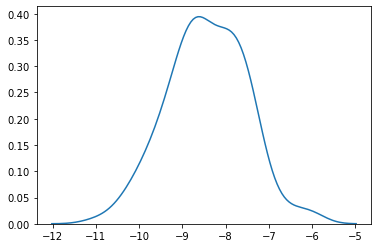

In [40]:
from seaborn import kdeplot
kdeplot(smina_score)

In [63]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df.head()

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,Binder or not,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,1,1390.0,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,0,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,0,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,0,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,0,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0


In [110]:
inhib_score = dict()

for smi,z in tqdm.tqdm_notebook(zip(df['SMILES'], df['ZINC ID'])):
    try:
        #convert the ligand:
        #!obabel -:"$smi" --gen3d ---errorlevel 1 --partial_charges gasteiger -O nam.pdbqt >/dev/null
        !obabel -:"$smi" --gen3d ---errorlevel 1  -O nam.pdbqt >/dev/null
    
        #perform docking:    
        !./smina.static -r 5WIU-receptor.pdbqt --quiet -l nam.pdbqt --cpu 2 --autobox_ligand 5WIU-CAC.pdbqt --autobox_add 8 --log hi.log --exhaustiveness 4 >/dev/null
    
        #get docking score:
        myvar = !sed -n 26,26p hi.log | awk '{print $2}' -
        
        if len(myvar)>0:
            inhib_score[z] = float(myvar[0])
            
    except KeyboardInterrupt:
        raise
    except:
        pass

1 molecule converted
1 molecule converted
1 molecule converted
*** Open Babel Error  in Do
  3D coordinate generation failed
1 molecule converted


An internal error occurred in ../../../src/lib/tree.h(133). 

Please report this error at http://smina.sf.net
Please remember to include the following in your problem report:
    * the EXACT error message,
    * your version of the program,
    * the type of computer system you are running it on,
	* all command line options,
	* configuration file (if used),
    * ligand file as PDBQT,
    * receptor file as PDBQT,
	* flexible side chains file as PDBQT (if used),
	* output file as PDBQT (if any),
    * input (if possible),
	* random seed the program used (this is printed when the program starts).

Thank you!
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 mole

1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule co



An internal error occurred in ../../../src/lib/tree.h(133). 

Please report this error at http://smina.sf.net
Please remember to include the following in your problem report:
    * the EXACT error message,
    * your version of the program,
    * the type of computer system you are running it on,
	* all command line options,
	* configuration file (if used),
    * ligand file as PDBQT,
    * receptor file as PDBQT,
	* flexible side chains file as PDBQT (if used),
	* output file as PDBQT (if any),
    * input (if possible),
	* random seed the program used (this is printed when the program starts).

Thank you!
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
1 molecule converted
*** Open Babel Error  in Do
  3D coordinate generation failed
1 molecule converted


An internal error occurred in ../../../src/lib/tree.h(133). 

Please report this error at http://smina.sf.net
Please remember to i

In [109]:
smi
!obabel -:"CCc1nc(CN2CCCc3cc(F)cc(C)c32)n[nH]1" --gen3d ---errorlevel 1  -O nam.pdbqt >/dev/null

'CCc1nc(CN2CCCc3cc(F)cc(C)c32)n[nH]1'

In [137]:
df = pd.read_csv('https://gist.githubusercontent.com/ljmartin/82f0dfe9f58e584a3e5186afe6e75973/raw/4315cb08931628f03781546da46c0b98875c453b/41586_2019_917_MOESM4_ESM.csv')
df.head()

,ZINC ID,Global Rank∗,Clustered Rank†,Energy,TC to knowns‡,Cosest neighbor among known DRD4 binders,Top-pick or not,Just from energy window,Energy window,Tested or not,Binder or not,D4 Ki(nM),D2 Ki(nM),D3 Ki(nM),cAMP EC50(nM),Inhibition (%) at 10uM,SMILES,Vendor ID,Charge from docked poses
0,ZINC000191583186,1,1,-75.5,0.30,ZINC000028347504,0,1,-75,1,1,1390.0,3860,1730,NT||,82.48,Cc1ccc(C[C@@H](CO)N[C@@H](C)CCc2ccccc2[N+](=O)...,Z1804039468,1.0
1,ZINC000159533726,2,2,-73.67,0.33,ZINC000103232405,0,1,-75,1,0,NaN,NaN,NaN,NT,2.68,C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@...,Z1514931360,1.0
2,ZINC000151228439,3,4,-73.47,0.34,ZINC000053274848,0,1,-75,1,0,NaN,NaN,NaN,NT,17.5,C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1,Z1419817479,1.0
3,ZINC000291023493,5,5,-72.95,0.31,ZINC000028363497,0,1,-75,1,0,NaN,NaN,NaN,NT,-10.33,C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N...,Z2179794811,2.0
4,ZINC000593577820,7,7,-72.5,0.35,ZINC000036216606,0,1,-75,1,0,NaN,NaN,NaN,NT,11.48,COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C,Z2480456501,1.0


In [138]:
pah = df.merge(pd.DataFrame({'ZINC ID':inhib_score.keys(), 'dscore':inhib_score.values()}), on='ZINC ID')

In [139]:
import numpy as np
#these are the docking scores:
docking_scores = np.array(pah['Energy'].str.strip('¶')).astype(float)

#first set the "not determined" records to zero inhibition:
pah.loc[pah['Inhibition (%) at 10uM'].str.contains('ND'), 'Inhibition (%) at 10uM'] = 0

#now these are the ligands that inhibit >50% at 10uM:
inhibition = np.array(pah['Inhibition (%) at 10uM']).astype(float)

In [140]:
docking_scores.shape

(540,)

In [141]:
inhibition.shape

(540,)

In [142]:
smina_score = pah['dscore']

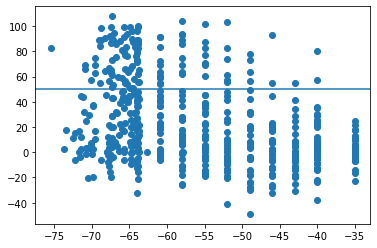

In [123]:
plt.scatter(docking_scores, inhibition)
plt.axhline(50)

<AxesSubplot:>

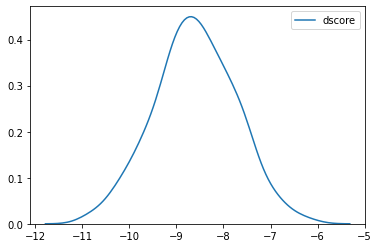

In [144]:
kdeplot(smina_score)

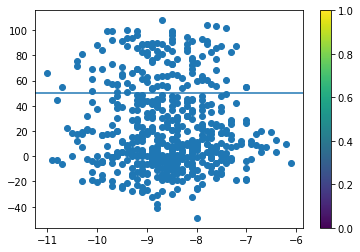

In [145]:
plt.scatter(smina_score, inhibition,)

plt.axhline(50)
plt.colorbar()

In [149]:
from scipy import stats
stats.pearsonr(smina_score, inhibition)#>50)

(-0.050284559051344435, 0.24339704988184988)

In [150]:
stats.pearsonr(docking_scores, inhibition)#>50)

(-0.3964948669546674, 8.967339207931744e-22)

In [132]:
stats.pearsonr(docking_scores, inhibition>50)

ValueError: x and y must have the same length.